# Turbofan Engine Remaining Useful Life (RUL) Prediction

This project aims to predict the Remaining Useful Life (RUL) of aircraft engines using sensor data from the NASA C-MAPSS FD001 dataset. An LSTM-based sequence model is used to learn degradation patterns and make RUL predictions.


## 1. Import Libraries


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


## 2. Load and Inspect Dataset


In [17]:
column_names = ['unit', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + \
               [f'sensor_{i}' for i in range(1, 22)]

df = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=column_names)
df.head()


,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [18]:
# Dataset overview
print("Shape:", df.shape)
print("Unique engines:", df['unit'].nunique())
df.info()


Shape: (20631, 26)
Unique engines: 100
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   unit          20631 non-null  int64  
 1   cycle         20631 non-null  int64  
 2   op_setting_1  20631 non-null  float64
 3   op_setting_2  20631 non-null  float64
 4   op_setting_3  20631 non-null  float64
 5   sensor_1      20631 non-null  float64
 6   sensor_2      20631 non-null  float64
 7   sensor_3      20631 non-null  float64
 8   sensor_4      20631 non-null  float64
 9   sensor_5      20631 non-null  float64
 10  sensor_6      20631 non-null  float64
 11  sensor_7      20631 non-null  float64
 12  sensor_8      20631 non-null  float64
 13  sensor_9      20631 non-null  float64
 14  sensor_10     20631 non-null  float64
 15  sensor_11     20631 non-null  float64
 16  sensor_12     20631 non-null  float64
 17  sensor_13     20631 non-null  

## 3. Preprocessing and Normalization


In [19]:
rul_df = df.groupby('unit')['cycle'].max().reset_index()
rul_df.columns = ['unit', 'max_cycle']
df = df.merge(rul_df, on='unit')
df['RUL'] = df['max_cycle'] - df['cycle']
df.drop(columns=['max_cycle'], inplace=True)

df['RUL'] = df['RUL'].clip(upper=125)
df['RUL'] = df['RUL'] / 125

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df.drop(columns=['unit', 'cycle', 'RUL']))


## 4. Sequence Generation for LSTM


In [20]:
def make_sequences(data, seq_len=30):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :])
        y.append(df['RUL'].values[i+seq_len])
    return np.array(X), np.array(y)

X, y = make_sequences(scaled_features)


## 5. Build and Train LSTM Model


In [21]:
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dense(1)
])

model.compile(loss='mse', optimizer='adam')
model.fit(X, y, epochs=10, batch_size=64, validation_split=0.2)

model.summary()

Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - loss: 0.0688 - val_loss: 0.0259
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - loss: 0.0208 - val_loss: 0.0228
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 42s 91ms/step - loss: 0.0176 - val_loss: 0.0226
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - loss: 0.0170 - val_loss: 0.0169
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - loss: 0.0157 - val_loss: 0.0152
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 43s 93ms/step - loss: 0.0162 - val_loss: 0.0166
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - loss: 0.0155 - val_loss: 0.0185
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - loss: 0.0151 - val_loss: 0.0145
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - loss: 0.0144 - val_loss: 0.0158
Epoch 10/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - loss: 0.0144 - val_loss: 0.0178


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 100)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,755 (940.45 KB)

 Trainable params: 80,251 (313.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 160,504 (626.97 KB)

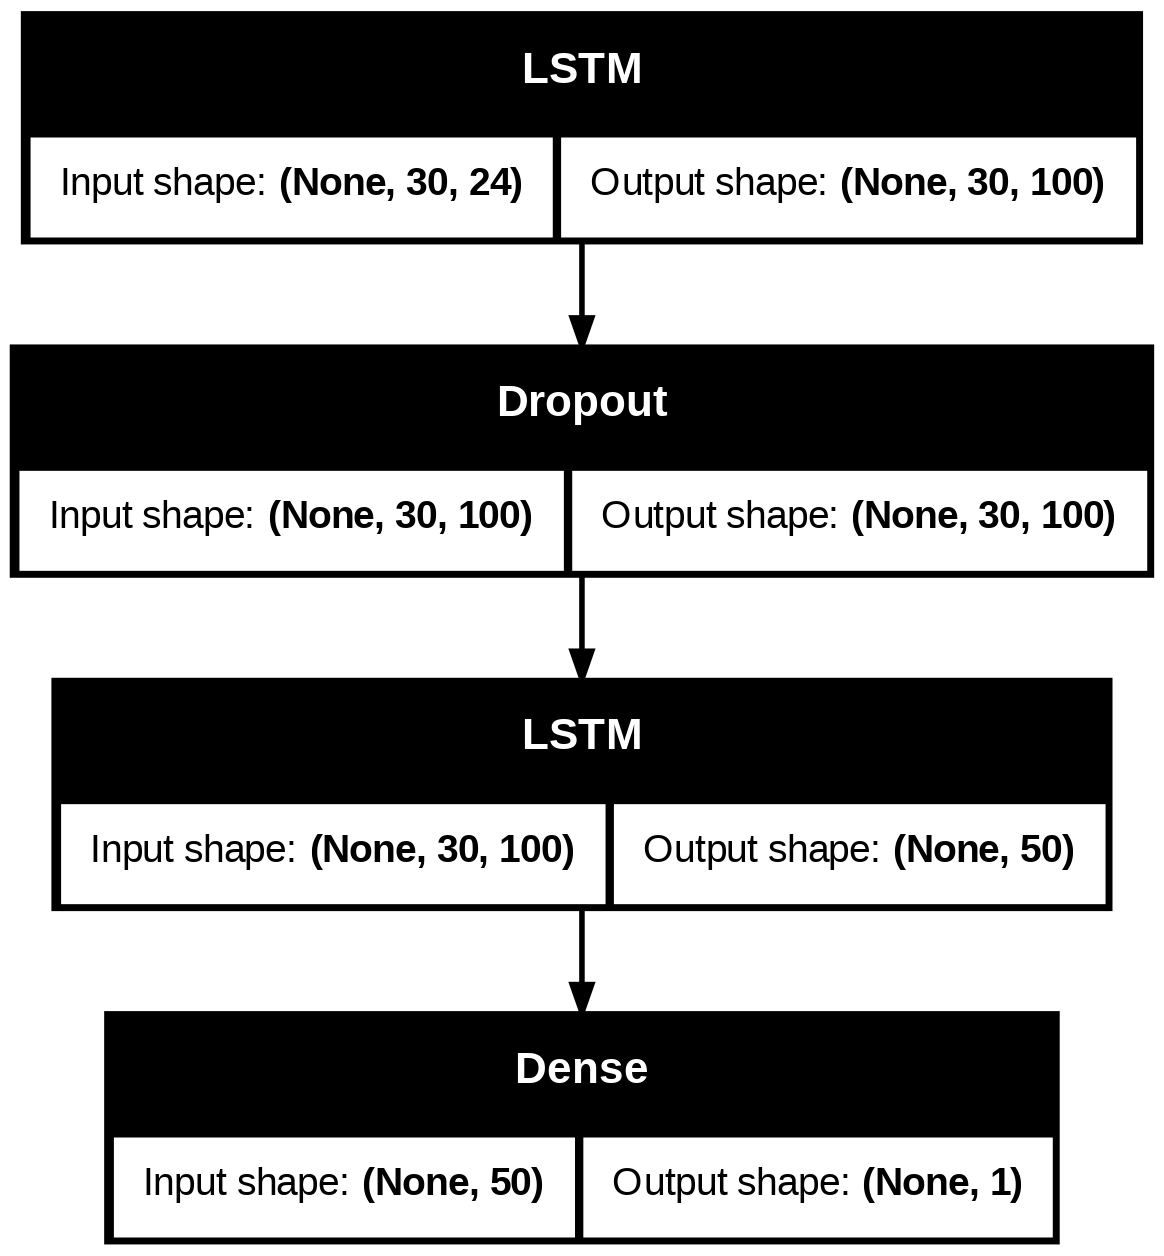

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

## 6. Evaluate Model on Training Data


In [23]:
y_pred = model.predict(X)
rmse = sqrt(mean_squared_error(y, y_pred))
print(f"Train RMSE: {rmse:.2f}")

644/644 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step
Train RMSE: 0.12


## 7. Visualize Predictions


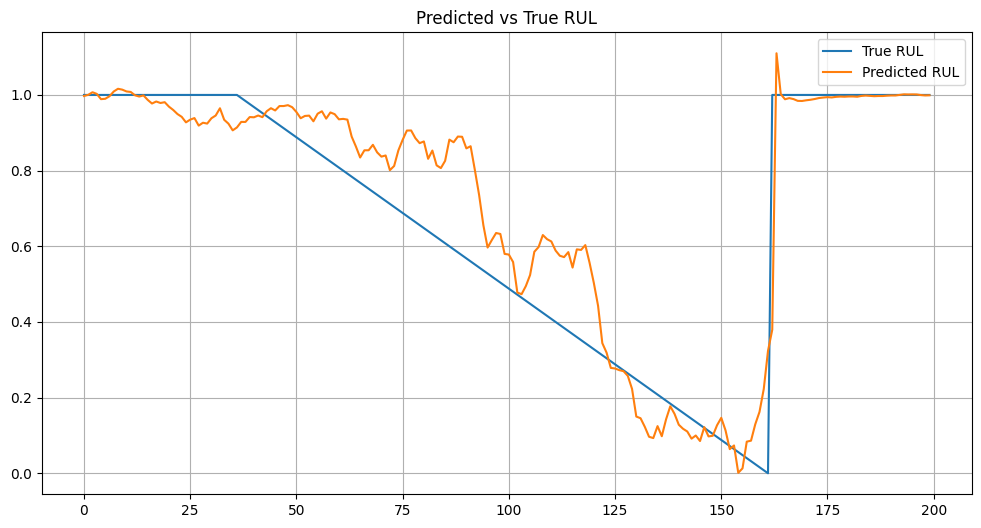

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(y[:200], label='True RUL')
plt.plot(y_pred[:200], label='Predicted RUL')
plt.legend()
plt.title("Predicted vs True RUL")
plt.grid(True)
plt.savefig("Train_Prediction.jpg")
plt.show()

## 8. Simulated Alerts


In [25]:
for pred in y_pred[:10]:
    if pred < 0.24:  # 30 cycles when scaled back (30/125 ≈ 0.24)
        print(f"ALERT: RUL = {pred[0]*125:.2f} cycles")

## 9. Predict RUL for Test Engines


In [26]:
test_df = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=column_names)
true_rul = pd.read_csv('RUL_FD001.txt', header=None)
true_rul.columns = ['RUL']

test_df['RUL'] = 0  # dummy
test_scaled = scaler.transform(test_df.drop(columns=['unit', 'cycle', 'RUL']))
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.columns[2:-1])
test_scaled_df['unit'] = test_df['unit'].values
test_scaled_df['cycle'] = test_df['cycle'].values

In [27]:
def get_last_sequences(df, seq_len=30):
    sequences = []
    unit_ids = df['unit'].unique()
    for unit in unit_ids:
        unit_data = df[df['unit'] == unit].sort_values('cycle')
        if len(unit_data) >= seq_len:
            seq = unit_data.iloc[-seq_len:,:-2].values
        else:
            pad = np.zeros((seq_len - len(unit_data), df.shape[1] - 2))
            seq = np.vstack((pad, unit_data.iloc[:, :-2].values))
        sequences.append(seq)
    return np.array(sequences)

X_test_final = get_last_sequences(test_scaled_df)

## 10. Final Evaluation on Test Set


In [28]:
predicted_rul = model.predict(X_test_final).flatten() * 125
true_rul_values = true_rul['RUL'].values

test_rmse = sqrt(mean_squared_error(true_rul_values, predicted_rul))
test_mae = mean_absolute_error(true_rul_values, predicted_rul)

print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Test RMSE: 16.38
Test MAE: 11.97


## 11. True vs Predicted RUL on Test Set


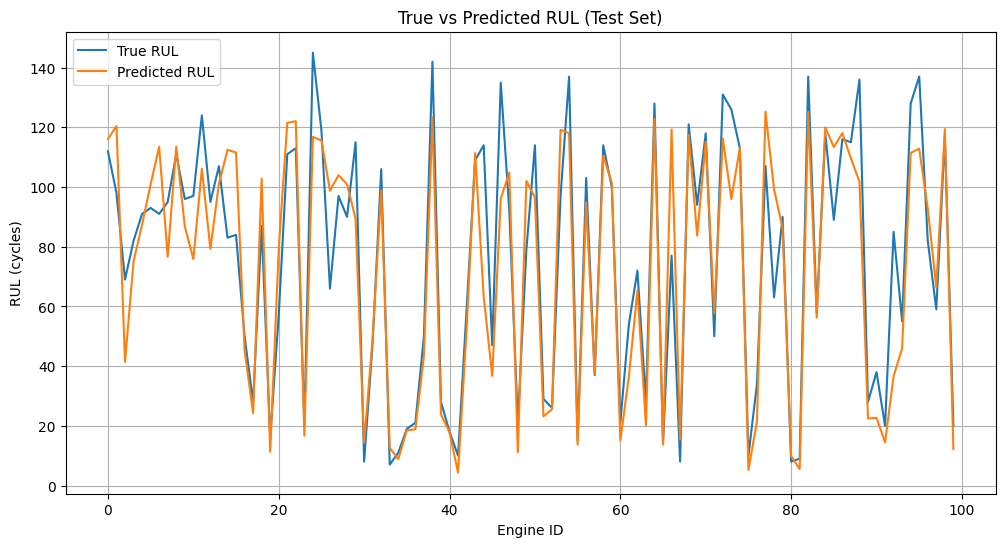

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(true_rul_values, label='True RUL')
plt.plot(predicted_rul, label='Predicted RUL')
plt.xlabel("Engine ID")
plt.ylabel("RUL (cycles)")
plt.legend()
plt.title("True vs Predicted RUL (Test Set)")
plt.grid(True)
plt.savefig("Test_Prediction.jpg")
plt.show()